In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import win32com.client
import sqlite3

import sys
from enum import Enum
import time
import pythoncom

import warnings
warnings.filterwarnings('ignore')

# matplotlib 그래프 한글지원
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False
if platform.system()== 'Windows':
    path= 'c:/Windows/Fonts/malgun.ttf'
    font_name= font_manager.FontProperties(fname=path).get_name()
    rc('font', family= font_name)
elif platform.system()=='Darwin':
    rc('font', family= 'AppleGothic')
else:
    print('포트를 지원하지 않습니다.')

In [2]:
# 코스닥 종목코드
kosdaq_df= None
with sqlite3.connect('./data/StockData3.sqlite') as conn:
    #kospi_df= pd.read_sql("SELECT * From '코스피_종목코드'", con=conn) # if_exists='append'
    kosdaq_df= pd.read_sql("SELECT * From '코스닥_종목코드'", con=conn) # if_exists='append'    
#print(kospi_df.shape)
print(kosdaq_df.shape)
#(1315, 9)

(1315, 9)


In [3]:
def sqlDataReader(code, 시작일자='20060101', 종료일자='20191201'):
    query= """
        SELECT 날짜, 시가, 고가, 저가, 종가, 거래량 FROM '코스닥_일별주가' WHERE 종목코드='%s' AND 날짜 BETWEEN '%s' AND '%s'
        ORDER BY 날짜 ASC
       """ %(code, 시작일자, 종료일자)
    # 코스피전체종목->일별주가
    # query= """
    #         SELECT 종목코드, 날짜, 시가, 고가, 저가, 종가, 거래량 FROM '코스피 일별주가' WHERE 날짜 BETWEEN '%s' AND '%s'
    #         ORDER BY 날짜 ASC
    #        """ %(시작일자, 종료일자)

    conn= sqlite3.connect('./data/StockData3.sqlite')
    df_local= pd.read_sql_query(query, con= conn)
    conn.close()
    
    df_local.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    df_local['Date1']= pd.to_datetime(df_local['Date'].values)
    df_local.set_index('Date1', inplace= True)
    df_local.dropna(inplace= True)
    print(df_local.shape)
    
    return df_local

In [4]:
company_dict= {}
for i in range(len(kosdaq_df)):
    company_dict[kosdaq_df['종목명'][i]] = kosdaq_df['종목코드'][i]
    
print(len(company_dict))
print(len(kosdaq_df))

1315
1315


In [5]:
# from datetime import timedelta

# last_day= datas_dict4[name][-1]
# last_day_str= last_day.strftime('%Y-%m-%d')
# last_day_range= pd.date_range(last_day_str, periods= 15, freq='B') # 15일 영업일
# s_temp = df.loc[last_day_range].Close
# for i in range(len(s_temp)):
#     if s_temp[i] == None:
#         break
#     target_change = ((s_temp[i] - s_temp[0]) / s_temp[0] * 100)  
#     if target_change < -15:
#         target_change= -15
#         break
#     if target_change > 15:
#         target_change= 15
#         break
# target_change

In [6]:
kosdaq_df[kosdaq_df['종목명']=='카페24']

,종목코드,종목명,구분,소속,업종,업종명,KOSPI200,상태,상장일
325,A042000,카페24,1,2,353,(코스닥)인터넷,0,0,20180208


In [7]:
datas_dict4['카페24']
# 상장일보다 빠른날짜가 검색되는 경우 처리    

NameError: name 'datas_dict4' is not defined

In [43]:
from datetime import timedelta
import pickle

with open('dic.p', 'rb') as f:
    datas_dict4= pickle.load(f)

    
def get_bool(s):
    if s > 0:
        return 1
    elif s <= 0:
        return 0
    

df0= None
df= None
cnt= 0
    
for name in datas_dict4.keys():
    
    code= company_dict[name]
    df= sqlDataReader(code)

    df['MA5']= df['Close'].rolling(window= 5).mean()
    df['MA10']= df['Close'].rolling(window= 10).mean()
    df['MA20']= df['Close'].rolling(window= 20).mean()
    df['MA60']= df['Close'].rolling(window= 60).mean()
    df['MA120']= df['Close'].rolling(window= 120).mean()

    df['VMA5']= df['Volume'].rolling(window= 5).mean()
    df['VMA20']= df['Volume'].rolling(window= 20).mean()
    df['VMA60']= df['Volume'].rolling(window= 60).mean()
    df['VMA120']= df['Volume'].rolling(window= 120).mean()

    for i in [5,10,20,60,120]:
        df['UP'+str(i)]= ((df['MA'+str(i)] - df['MA'+str(i)].shift(1)).apply(get_bool)) #1

    for i in [5,20,60,120]:
        df['VUP'+str(i)]= ((df['VMA'+str(i)] - df['VMA'+str(i)].shift(1)).apply(get_bool)) #2

    df['ON5_10']= ((df['MA5'] - df['MA10']).apply(get_bool)) #3
    df['ON5_20']= ((df['MA5'] - df['MA20']).apply(get_bool)) #3
    df['ON5_60']= ((df['MA5'] - df['MA60']).apply(get_bool)) #3
    df['ON5_120']= ((df['MA5'] - df['MA120']).apply(get_bool)) #3
    df['ON10_20']= ((df['MA10'] - df['MA20']).apply(get_bool)) #3
    df['ON10_60']= ((df['MA10'] - df['MA60']).apply(get_bool)) #3
    df['ON10_120']= ((df['MA10'] - df['MA120']).apply(get_bool)) #3
    df['ON20_60']= ((df['MA20'] - df['MA60']).apply(get_bool)) #3
    df['ON20_120']= ((df['MA20'] - df['MA120']).apply(get_bool)) #3
    df['ON60_120']= ((df['MA60'] - df['MA120']).apply(get_bool)) #3

    for i in [5,10,20,60,120]:
        df['ONC'+str(i)]= ((df['Close'] - df['MA'+str(i)]).apply(get_bool)) #4

    for i in [5,20,60,120]:
        df['ONV'+str(i)]= ((df['Volume'] - df['VMA'+str(i)]).apply(get_bool)) #5

    for i in [5,10,20,60,120]:
        df['Disp'+str(i)]= (df['Close'] - df['MA'+str(i)]) / df['MA'+str(i)] * 100 #6

    for i in [5,10,20,60,120]:
        df['Grad'+str(i)]= (df['MA'+str(i)] - df['MA'+str(i)].shift(1)) / df['MA'+str(i)] * 100 #7

    for i in [1,2,4,7,12,20,33,54,68]:
        df['RC'+ str(i)]= (df['Close'] - df['Close'].shift(i)) / df['Close'] * 100 #8

    df['Target1'] = (df['Close'].shift(-1) - df['Close']) / df['Close'] * 100
    df['Target'] = (df['Close'].shift(-1) - df['Close']) / df['Close'] * 100

    for i in range(0,15):
        df['Target'] = df['Target1'].shift(-1*i) * (0.85**i) + df['Target']    
        
   
    for i in range(1,14):
        df['FC'+ str(i)]= (df['Close'].shift(-1*i) - df['Close']) / df['Close'] * 100

    ##########################################################
    chg_v_list= []
    chg = None
     
    for idx in range(len(df.Close)):
        if df.index[idx] in datas_dict4[name]:                        
            for i in range(1,14):
                try:
                    chg = (df.iloc[idx + i, 4] - df.iloc[idx, 4])/ df.iloc[idx, 4] * 100
                    if chg > 18:
                        chg_v = 18
                        break
                    elif chg < -18:
                        chg_v = -18
                    else:
                        chg_v = chg
                except:
                    chg = None

        chg_v_list.append(chg_v)

    df['Target2'] = pd.Series(chg_v_list, index= df.index)
    ##########################################################
        

    df = df.loc[datas_dict4[name]]
    del df['Target1']
    #df.drop(df.columns[0:15], axis=1, inplace= True)
    df.reset_index(inplace= True)
    df['Code']= code
    df = df[['Code'] + list(df.columns[:-1])]

    df0= pd.concat([df0, df])
    
#     cnt += 1
#     if cnt > 1:
#         break

df0.reset_index(inplace= True)
df0.drop('index', axis=1, inplace= True)

(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(527, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(1838, 6)
(2552, 6)
(2552, 6)
(2014, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2464, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(818, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(1931, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2552, 6)
(2

(1338, 6)
(465, 6)
(1323, 6)
(1406, 6)
(1363, 6)
(1335, 6)
(574, 6)
(1078, 6)
(681, 6)
(879, 6)
(590, 6)
(1429, 6)
(1160, 6)
(939, 6)
(383, 6)
(1071, 6)
(1332, 6)
(1361, 6)
(1371, 6)
(1311, 6)
(1069, 6)
(1156, 6)
(1220, 6)
(1032, 6)
(1064, 6)
(911, 6)
(846, 6)
(816, 6)
(1098, 6)
(1225, 6)
(1166, 6)
(1152, 6)
(1062, 6)
(573, 6)
(583, 6)
(1089, 6)
(901, 6)
(1204, 6)
(1125, 6)
(1153, 6)
(1063, 6)
(1070, 6)
(1168, 6)
(1123, 6)
(1089, 6)
(1088, 6)
(998, 6)
(1097, 6)
(1081, 6)
(1094, 6)
(1074, 6)
(818, 6)
(1072, 6)
(1069, 6)
(1064, 6)
(1069, 6)
(1062, 6)
(1064, 6)
(842, 6)
(833, 6)
(998, 6)
(1005, 6)
(843, 6)
(987, 6)
(985, 6)
(978, 6)
(969, 6)
(972, 6)
(584, 6)
(975, 6)
(877, 6)
(947, 6)
(949, 6)
(941, 6)
(953, 6)
(829, 6)
(947, 6)
(939, 6)
(877, 6)
(671, 6)
(923, 6)
(948, 6)
(907, 6)
(940, 6)
(920, 6)
(897, 6)
(795, 6)
(894, 6)
(912, 6)
(907, 6)
(817, 6)
(748, 6)
(821, 6)
(877, 6)
(873, 6)
(861, 6)
(730, 6)
(872, 6)
(749, 6)
(679, 6)
(822, 6)
(774, 6)
(816, 6)
(598, 6)
(814, 6)
(607, 6)
(4

In [47]:
df0.dropna(inplace= True)

In [48]:
# df0.isnull().sum()

In [49]:
df0.shape

(12519, 79)

In [14]:
#df0.to_csv('./result_df0_190504.csv')

In [79]:
df0= pd.read_csv('./result_df0_190504.csv')
del df0[df0.columns[0]]
print(df0.shape)
df0.head()

(12003, 79)


,Code,Date1,Date,Open,High,Low,Close,Volume,MA5,MA10,...,FC5,FC6,FC7,FC8,FC9,FC10,FC11,FC12,FC13,Target2
0,A000250,2012-10-04,20121004,2540,2590,2540,2560,131673.0,2558.0,2577.0,...,7.617188,9.375000,10.156250,7.226562,12.890625,5.468750,4.882812,2.539062,4.687500,4.687500
1,A000250,2012-10-05,20121005,2565,2620,2515,2565,308022.0,2553.0,2575.5,...,9.161793,9.941520,7.017544,12.670565,5.263158,4.678363,2.339181,4.483431,4.483431,4.483431
2,A000440,2010-06-09,20100609,3425,3425,3245,3345,2970.0,3348.0,3356.5,...,-7.772795,-8.819133,-8.968610,-9.417040,-10.313901,-7.473842,-8.221226,-8.669656,-10.911809,-10.911809
3,A000440,2010-06-10,20100610,3340,3420,3210,3245,970.0,3325.0,3350.5,...,-6.009245,-6.163328,-6.625578,-7.550077,-4.622496,-5.392912,-5.855162,-8.166410,-8.012327,-8.012327
4,A000440,2010-06-11,20100611,3260,3385,3160,3240,5020.0,3289.0,3342.0,...,-6.018519,-6.481481,-7.407407,-4.475309,-5.246914,-5.709877,-8.024691,-7.870370,-10.185185,-10.185185


In [80]:
df0 = df0[df0.Volume > 100] # 거래량 작은건 제외

0.7478345262593126


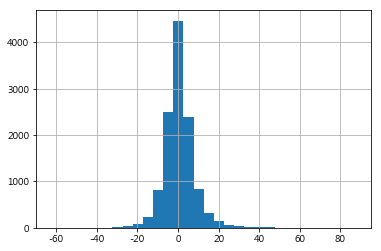

In [81]:
print(df0.Target.mean())
df0.Target.hist(bins=30)

In [82]:
print(len(df0[df0.Target > 0]))
print(len(df0[df0.Target < 0]))

6175
5827


In [83]:
print('5보다 크다  ', len(df0[df0.Target > 5]))
print('5~0사이     ', len(df0[(df0.Target < 5) & (df0.Target > 0) ]))
print('0~-5사이    ', len(df0[(df0.Target > -5) & (df0.Target <= 0) ]))
print('-5보다 작다 ', len(df0[df0.Target < -5]))

5보다 크다   2464
5~0사이      3711
0~-5사이     3860
-5보다 작다  1968


0.7338040059296611


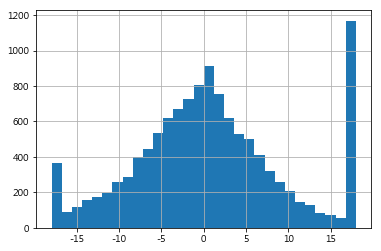

In [84]:
print(df0.Target2.mean())
df0.Target2.hist(bins=30)

In [85]:
print(len(df0[df0.Target2 > 0]))
print(len(df0[df0.Target2 < 0]))

6004
5840


In [86]:
print('18보다 크다  ', len(df0[df0.Target2 >= 18]))
print('15~5사이     ', len(df0[(df0.Target2 < 15) & (df0.Target2 > 5) ]))
print('5~0사이     ', len(df0[(df0.Target2 < 5) & (df0.Target2 > 0) ]))
print('0~-5사이    ', len(df0[(df0.Target2 > -5) & (df0.Target2 < 0) ]))
print('-5~-15사이     ', len(df0[(df0.Target2 < -5) & (df0.Target2 > -15) ]))
print('-18보다 작다 ', len(df0[df0.Target2 <= -18]))

18보다 크다   1131
15~5사이      2011
5~0사이      2739
0~-5사이     2913
-5~-15사이      2422
-18보다 작다  286


In [87]:
def f1(x):
    if x > 5: # 5프로 이상
        y=1
    elif x < -5: # -5프로 이하
        y=-1
    else:
        y=0
    return y

In [88]:
df0['Target3']= pd.Series(map(f1,df0['Target2']))
df0.head()

,Code,Date1,Date,Open,High,Low,Close,Volume,MA5,MA10,...,FC6,FC7,FC8,FC9,FC10,FC11,FC12,FC13,Target2,Target3
0,A000250,2012-10-04,20121004,2540,2590,2540,2560,131673.0,2558.0,2577.0,...,9.375000,10.156250,7.226562,12.890625,5.468750,4.882812,2.539062,4.687500,4.687500,0
1,A000250,2012-10-05,20121005,2565,2620,2515,2565,308022.0,2553.0,2575.5,...,9.941520,7.017544,12.670565,5.263158,4.678363,2.339181,4.483431,4.483431,4.483431,0
2,A000440,2010-06-09,20100609,3425,3425,3245,3345,2970.0,3348.0,3356.5,...,-8.819133,-8.968610,-9.417040,-10.313901,-7.473842,-8.221226,-8.669656,-10.911809,-10.911809,-1
3,A000440,2010-06-10,20100610,3340,3420,3210,3245,970.0,3325.0,3350.5,...,-6.163328,-6.625578,-7.550077,-4.622496,-5.392912,-5.855162,-8.166410,-8.012327,-8.012327,-1
4,A000440,2010-06-11,20100611,3260,3385,3160,3240,5020.0,3289.0,3342.0,...,-6.481481,-7.407407,-4.475309,-5.246914,-5.709877,-8.024691,-7.870370,-10.185185,-10.185185,-1


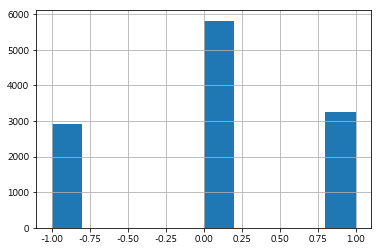

In [89]:
df0['Target3'].hist()

In [90]:
df_TR = pd.get_dummies(df0['Target3'], prefix= 'TR')
df0= df0.join(df_TR)

In [91]:
df0.head()

,Code,Date1,Date,Open,High,Low,Close,Volume,MA5,MA10,...,FC9,FC10,FC11,FC12,FC13,Target2,Target3,TR_-1,TR_0,TR_1
0,A000250,2012-10-04,20121004,2540,2590,2540,2560,131673.0,2558.0,2577.0,...,12.890625,5.468750,4.882812,2.539062,4.687500,4.687500,0,0,1,0
1,A000250,2012-10-05,20121005,2565,2620,2515,2565,308022.0,2553.0,2575.5,...,5.263158,4.678363,2.339181,4.483431,4.483431,4.483431,0,0,1,0
2,A000440,2010-06-09,20100609,3425,3425,3245,3345,2970.0,3348.0,3356.5,...,-10.313901,-7.473842,-8.221226,-8.669656,-10.911809,-10.911809,-1,1,0,0
3,A000440,2010-06-10,20100610,3340,3420,3210,3245,970.0,3325.0,3350.5,...,-4.622496,-5.392912,-5.855162,-8.166410,-8.012327,-8.012327,-1,1,0,0
4,A000440,2010-06-11,20100611,3260,3385,3160,3240,5020.0,3289.0,3342.0,...,-5.246914,-5.709877,-8.024691,-7.870370,-10.185185,-10.185185,-1,1,0,0


# 신경망 적용

In [123]:
df0c = df0[:].copy()

In [124]:
df0c.columns

Index(['Code', 'Date1', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume',
       'MA5', 'MA10', 'MA20', 'MA60', 'MA120', 'VMA5', 'VMA20', 'VMA60',
       'VMA120', 'UP5', 'UP10', 'UP20', 'UP60', 'UP120', 'VUP5', 'VUP20',
       'VUP60', 'VUP120', 'ON5_10', 'ON5_20', 'ON5_60', 'ON5_120', 'ON10_20',
       'ON10_60', 'ON10_120', 'ON20_60', 'ON20_120', 'ON60_120', 'ONC5',
       'ONC10', 'ONC20', 'ONC60', 'ONC120', 'ONV5', 'ONV20', 'ONV60', 'ONV120',
       'Disp5', 'Disp10', 'Disp20', 'Disp60', 'Disp120', 'Grad5', 'Grad10',
       'Grad20', 'Grad60', 'Grad120', 'RC1', 'RC2', 'RC4', 'RC7', 'RC12',
       'RC20', 'RC33', 'RC54', 'RC68', 'Target', 'FC1', 'FC2', 'FC3', 'FC4',
       'FC5', 'FC6', 'FC7', 'FC8', 'FC9', 'FC10', 'FC11', 'FC12', 'FC13',
       'Target2', 'Target3', 'TR_-1', 'TR_0', 'TR_1'],
      dtype='object')

In [125]:
df0c.drop(df0c.columns[1:17], axis=1, inplace= True)
#df0.drop(df0.columns[-19:-3], axis=1, inplace= True)
df0c.drop(df0c.columns[-38:-3], axis=1, inplace= True)

In [126]:
df0c.columns

Index(['Code', 'UP5', 'UP10', 'UP20', 'UP60', 'UP120', 'VUP5', 'VUP20',
       'VUP60', 'VUP120', 'ON5_10', 'ON5_20', 'ON5_60', 'ON5_120', 'ON10_20',
       'ON10_60', 'ON10_120', 'ON20_60', 'ON20_120', 'ON60_120', 'ONC5',
       'ONC10', 'ONC20', 'ONC60', 'ONC120', 'ONV5', 'ONV20', 'ONV60', 'ONV120',
       'TR_-1', 'TR_0', 'TR_1'],
      dtype='object')

In [24]:
for col in df0c.columns[-22:-3]:
    
    x= df0c[col]
    max_x = x.mean() + 2*x.std()
    min_x = x.mean() - 2*x.std()
    k = (x - min_x) / (max_x - min_x)
    k= k.apply(lambda v:1 if v > 1 else v)
    k= k.apply(lambda v:0 if v < 0 else v)
    df0c[col] = k 


In [129]:
# 랜덤하게 섞은 다음 train set과 test set을 나눈다.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df0c[df0c.columns[1:-3]], df0c[[df0c.columns[-3],df0c.columns[-1]]], test_size=0.2, shuffle= True)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9602, 28)
(9602, 2)
(2401, 28)
(2401, 2)


In [122]:
#1- y_train.sum() / len(y_train)

0.7595292647365133

In [131]:
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [132]:
print('훈련 세트 정확도: {:.3f}'.format(rf.score(X_train, y_train)))
print('테스트 세트 정확도: {:.3f}'.format(rf.score(X_test, y_test)))

훈련 세트 정확도: 0.810
테스트 세트 정확도: 0.451


Text(0, 0.5, 'feature')

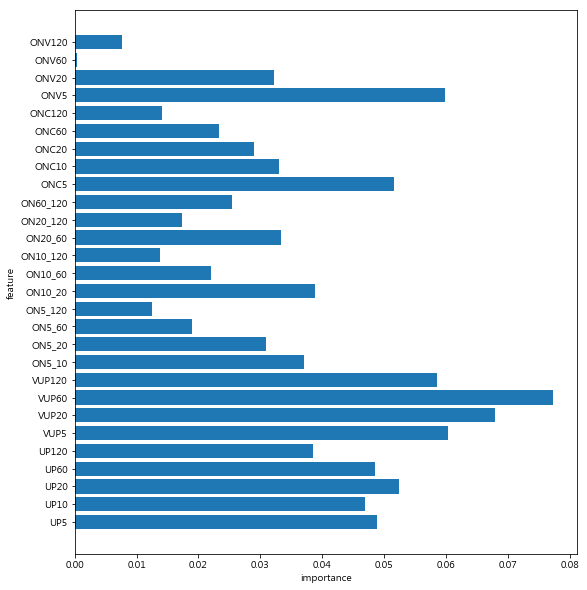

In [133]:
n_features= X_train.shape[1]

fig= plt.figure(figsize=(9,10))
plt.barh(range(n_features), rf.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel('importance')
plt.ylabel('feature')
#plt.ylim(-1, n_features)


In [104]:
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm

#rf= LinearRegression()

rf=svm.SVC(kernel='rbf',C=0.1,gamma=0.1)


# rf= GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                    max_depth=4, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10,
#                                    loss='huber', random_state =18)

rf.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [105]:
print('훈련 세트 정확도: {:.3f}'.format(rf.score(X_train, y_train)))
print('테스트 세트 정확도: {:.3f}'.format(rf.score(X_test, y_test)))

훈련 세트 정확도: 0.760
테스트 세트 정확도: 0.745


In [110]:
import keras
from keras import layers, models
import random as rd
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from sklearn.metrics import accuracy_score
from keras import optimizers
from keras import regularizers

#np.random.seed(5)

keras.backend.clear_session()
model = keras.models.Sequential()

model.add( layers.Dense(20, input_shape=(X_train.shape[1],), activation='relu' ))
model.add( layers.Dense(10, activation='relu' ))
#model.add( layers.Dense(20, activation='relu' ))
#model.add( layers.Dense(3, activation='softmax'))
model.add( layers.Dense(1, activation='sigmoid'))

# model.compile(loss = 'mse', optimizer = 'adam', metrics =['mae']) 

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model.compile(optimizer=optimizers.RMSprop(lr=0.001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])


model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                580       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


In [111]:
# 데이터 학습
history = model.fit(X_train, y_train, epochs= 200, batch_size = 500, verbose=1, validation_data=(X_test, y_test) )

Train on 9602 samples, validate on 2401 samples
Epoch 1/200
9602/9602 [==============================] - 0s 19us/step - loss: 0.6628 - acc: 0.6724 - val_loss: 0.6307 - val_acc: 0.7376
Epoch 2/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.6055 - acc: 0.7568 - val_loss: 0.5973 - val_acc: 0.7447
Epoch 3/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5794 - acc: 0.7594 - val_loss: 0.5865 - val_acc: 0.7447
Epoch 4/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5701 - acc: 0.7595 - val_loss: 0.5798 - val_acc: 0.7447
Epoch 5/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5639 - acc: 0.7595 - val_loss: 0.5736 - val_acc: 0.7447
Epoch 6/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5592 - acc: 0.7595 - val_loss: 0.5694 - val_acc: 0.7447
Epoch 7/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5552 - acc: 0.7595 - val_loss: 0.5663 - val_acc: 0.7447
Epoch 

Epoch 61/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5338 - acc: 0.7595 - val_loss: 0.5571 - val_acc: 0.7447
Epoch 62/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5335 - acc: 0.7595 - val_loss: 0.5573 - val_acc: 0.7447
Epoch 63/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5337 - acc: 0.7595 - val_loss: 0.5571 - val_acc: 0.7447
Epoch 64/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5333 - acc: 0.7595 - val_loss: 0.5584 - val_acc: 0.7447
Epoch 65/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5329 - acc: 0.7595 - val_loss: 0.5578 - val_acc: 0.7443
Epoch 66/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5328 - acc: 0.7595 - val_loss: 0.5577 - val_acc: 0.7439
Epoch 67/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5327 - acc: 0.7595 - val_loss: 0.5577 - val_acc: 0.7439
Epoch 68/200
9602/9602 [========================

9602/9602 [==============================] - 0s 3us/step - loss: 0.5255 - acc: 0.7599 - val_loss: 0.5622 - val_acc: 0.7434
Epoch 122/200
9602/9602 [==============================] - 0s 4us/step - loss: 0.5252 - acc: 0.7600 - val_loss: 0.5606 - val_acc: 0.7439
Epoch 123/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5252 - acc: 0.7604 - val_loss: 0.5619 - val_acc: 0.7443
Epoch 124/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5246 - acc: 0.7605 - val_loss: 0.5606 - val_acc: 0.7434
Epoch 125/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5249 - acc: 0.7610 - val_loss: 0.5617 - val_acc: 0.7451
Epoch 126/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5247 - acc: 0.7605 - val_loss: 0.5618 - val_acc: 0.7447
Epoch 127/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5245 - acc: 0.7607 - val_loss: 0.5622 - val_acc: 0.7443
Epoch 128/200
9602/9602 [==============================

Epoch 181/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5181 - acc: 0.7638 - val_loss: 0.5649 - val_acc: 0.7455
Epoch 182/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5181 - acc: 0.7639 - val_loss: 0.5666 - val_acc: 0.7430
Epoch 183/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5177 - acc: 0.7632 - val_loss: 0.5656 - val_acc: 0.7418
Epoch 184/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5181 - acc: 0.7633 - val_loss: 0.5663 - val_acc: 0.7451
Epoch 185/200
9602/9602 [==============================] - 0s 2us/step - loss: 0.5175 - acc: 0.7633 - val_loss: 0.5671 - val_acc: 0.7455
Epoch 186/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5176 - acc: 0.7640 - val_loss: 0.5671 - val_acc: 0.7443
Epoch 187/200
9602/9602 [==============================] - 0s 3us/step - loss: 0.5174 - acc: 0.7637 - val_loss: 0.5660 - val_acc: 0.7443
Epoch 188/200
9602/9602 [================

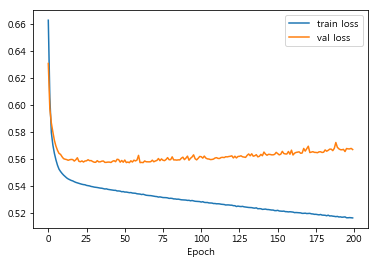

In [113]:
# loss: 0.0396 - mean_absolute_error: 0.1513 - val_loss: 0.0407 - val_mean_absolute_error: 0.1517
# loss: 0.0387 - mean_absolute_error: 0.1478 - val_loss: 0.0406 - val_mean_absolute_error: 0.1527

if not isinstance(history, dict):
    history = history.history

plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
# plt.title('Accuracy : Training vs Validation')
# plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

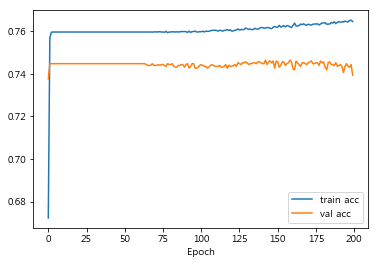

In [114]:
plt.plot(history['acc'], label='train acc')
plt.plot(history['val_acc'], label='val acc')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()